In [66]:
import os
import glob
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sounddevice as sd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

##### Converts Genre code (string) to integer label (0-based)

In [67]:
genre_map = {
    "01": 0, # Blues
    "02": 1, # Classical
    "03": 2, # Country
    "04": 3, # Disco
    "05": 4, # Hip-Hop
    "06": 5, # Jazz
    "07": 6, # Metal
    "08": 7, # Pop
    "09": 8, # Reggae
    "10": 9  # Rock
}

genre_labels = ["Blues", "Classical", "Country", "Disco", "Hip-Hop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

In [68]:
def extract_statistical_features(file_path, n_mfcc=13):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        delta_mean = np.mean(mfcc_delta, axis=1)
        delta_std = np.std(mfcc_delta, axis=1)
        delta2_mean = np.mean(mfcc_delta2, axis=1)
        delta2_std = np.std(mfcc_delta2, axis=1)
        features = np.concatenate([mfcc_mean, mfcc_std, delta_mean, delta_std, delta2_mean, delta2_std])
        return features, y, sr, mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None, None, None

In [69]:
def get_mfcc_image(file_path, n_mfcc=13, max_len=216):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        # Pad or truncate the MFCC to have a fixed number of frames (max_len)
        mfcc_fixed = librosa.util.fix_length(mfcc, size=max_len, axis=1)
        return mfcc_fixed
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [70]:
#https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
path = "Genres"

song_files = glob.glob(os.path.join(path, '**', '*.wav'), recursive=True)
print("Number of audio files found:", len(song_files))

Number of audio files found: 999


In [71]:
features_list = []
labels_list = []
waveforms = []
sample_rates = []
mfccs = []
file_names = []

cnn_images = []

In [72]:
for file_path in song_files:
    # Extracting features from the audio file
    features, y, sr, mfcc = extract_statistical_features(file_path, n_mfcc=13)
    if features is not None:
        features_list.append(features)
        waveforms.append(y)
        sample_rates.append(sr)
        mfccs.append(mfcc)
        file_names.append(file_path)
        
        # Parse the filename to extract the emotion code (3rd part of the filename)
        base_name = os.path.basename(file_path)
        parts = base_name.split('.')
        if len(parts) >= 1:
            genre_code = parts[0].lower()
            
            for label, label_name in enumerate(genre_labels):
                if label_name.lower() == genre_code:
                    labels_list.append(label)
                    break
            else:
                labels_list.append(-1)  # Unknown genre
        else:
            labels_list.append(-1)

In [79]:
features_array = np.array(features_list)
labels_array = np.array(labels_list)


print("Features array shape (Random Forest):", features_array.shape)
print("Labels array shape:", labels_array.shape)

Features array shape (Random Forest): (999, 78)
Labels array shape: (999,)


In [90]:
example_index = 2
y_example = waveforms[example_index]
sr_example = sample_rates[example_index]
mfcc_example = mfccs[example_index]
file_name_example = file_names[example_index]

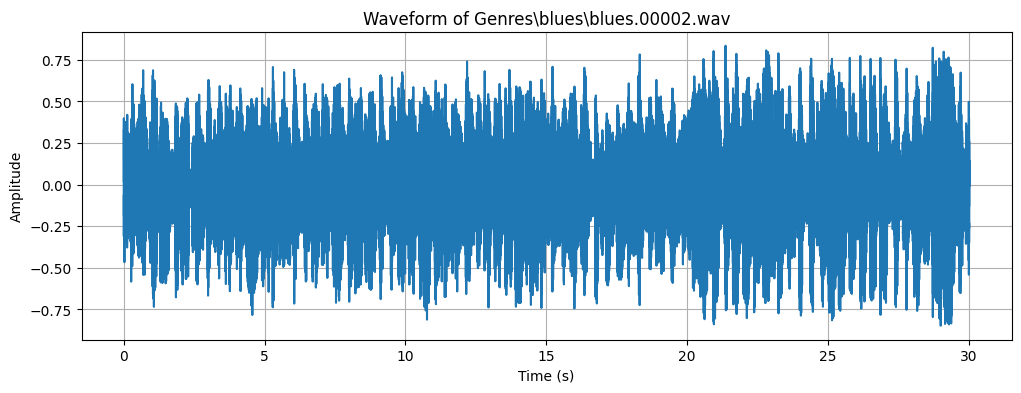

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [91]:
t = np.arange(len(y_example)) / sr_example
plt.figure(figsize=(12, 4))
plt.plot(t, y_example)
plt.title(f"Waveform of {file_name_example}")
plt.xlabel("Time (s)")  
plt.ylabel("Amplitude")
plt.grid()
plt.show()
plt.figure(figsize=(12, 4))


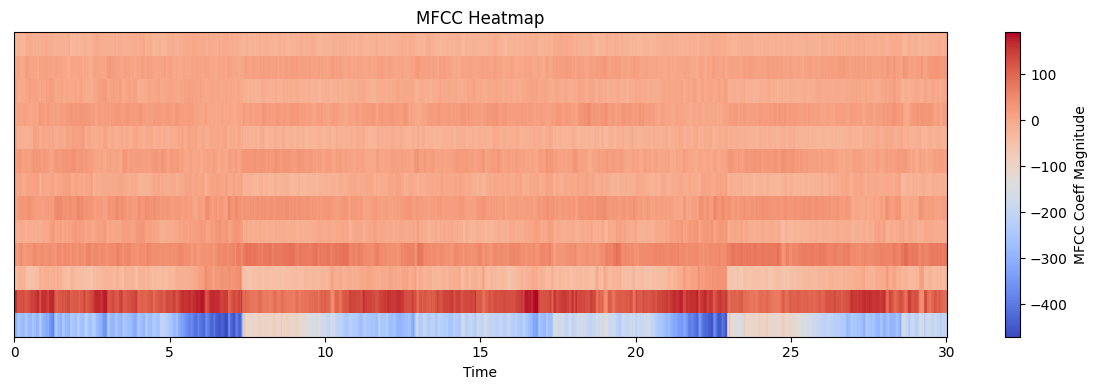

In [92]:
# CODE
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar(label='MFCC Coeff Magnitude')
plt.title("MFCC Heatmap")
plt.tight_layout()
plt.show()

In [93]:
# CODE
X_train, X_test, y_train, y_test = train_test_split(
    features_array, 
    labels_array, 
    test_size=0.2,    # 20% test split
    random_state=42   # for reproducible results
)

print("Train set size:", X_train.shape, "Test set size:", X_test.shape)

Train set size: (799, 78) Test set size: (200, 78)


In [94]:
# CODE
# Instantiate and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("Random Forest training complete.")

Random Forest training complete.


In [88]:
# CODE
# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100

# Print evaluation metrics
print(f"Test Accuracy (fraction): {accuracy:.4f}")
print(f"Test Accuracy (percentage): {accuracy_percentage:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy (fraction): 0.6500
Test Accuracy (percentage): 65.00%

Classification Report:
              precision    recall  f1-score   support

          -1       0.53      0.67      0.59        15
           0       0.60      0.57      0.59        21
           1       0.71      1.00      0.83        12
           2       0.57      0.54      0.55        24
           3       0.64      0.64      0.64        22
           5       0.91      0.78      0.84        27
           6       0.62      0.83      0.71        18
           7       0.81      0.89      0.85        19
           8       0.59      0.45      0.51        22
           9       0.43      0.30      0.35        20

    accuracy                           0.65       200
   macro avg       0.64      0.67      0.65       200
weighted avg       0.65      0.65      0.64       200



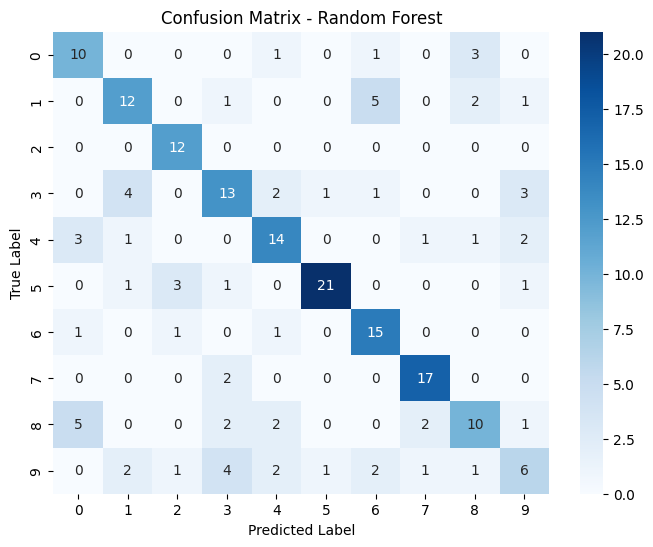

In [95]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [96]:
# Save the Random Forest model
joblib.dump(rf_model, "random_forest_modEEEl.pkl")
print("Random Forest model saved as random_forest_modEEEl.pkl")

Random Forest model saved as random_forest_modEEEl.pkl


In [97]:
# Load the Random Forest model
rf_clf = joblib.load("random_forest_modEEEl.pkl")
print("Random Forest model loaded successfully.")

Random Forest model loaded successfully.


In [106]:
# Set source = 'file' to use an external audio file (e.g., 'new_audio.wav')
# Set source = 'mic' to record audio from the microphone

source = 'mic'  # Change to 'file' if you want to use an external file

if source == 'file':
    # Inference using an external audio file
    new_audio_path = 'new_audio.wav'  # Provide the path to your audio file
    
    # Extract features for the Random Forest model
    features_new, y_new, sr_new, mfcc_new = extract_statistical_features(new_audio_path, n_mfcc=13)
    if features_new is not None:
        features_new = features_new.reshape(1, -1)
    

elif source == 'mic':
    duration = 10  # seconds to record
    fs = 48000   # Sampling rate
    print(f"Recording audio for {duration} seconds...")
    recording = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
    sd.wait() 
    y_new = recording.flatten()  
    sr_new = fs
    print("Recording complete.")

    mfcc_record = librosa.feature.mfcc(y=y_new, sr=sr_new, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc_record)
    mfcc_delta2 = librosa.feature.delta(mfcc_record, order=2)
    mfcc_mean = np.mean(mfcc_record, axis=1)
    mfcc_std = np.std(mfcc_record, axis=1)
    delta_mean = np.mean(mfcc_delta, axis=1)
    delta_std = np.std(mfcc_delta, axis=1)
    delta2_mean = np.mean(mfcc_delta2, axis=1)
    delta2_std = np.std(mfcc_delta2, axis=1)
    
    # Concatenate statistical features for Random Forest prediction
    features_new = np.concatenate([mfcc_mean, mfcc_std, delta_mean, delta_std, delta2_mean, delta2_std]).reshape(1, -1)

    
    # For the CNN model, create a fixed-size MFCC image
    max_len = 216
    mfcc_img_new = librosa.util.fix_length(mfcc_record, size=max_len, axis=1)
    mfcc_img_new = mfcc_img_new[np.newaxis, ..., np.newaxis]
else:
    raise ValueError("Invalid source selected. Please set source to 'file' or 'mic'.")

Recording audio for 10 seconds...
Recording complete.


In [107]:
genre_labels = ["Blues", "Classical", "Country", "Disco", "Hip-Hop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]

rf_pred_new = rf_clf.predict(features_new)[0]

print("Random Forest Prediction:", genre_labels[rf_pred_new])

Random Forest Prediction: Jazz
